In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## 1) Reading data:

In [9]:
# Load data and look at it
data = pd.read_csv('data/AirPassengers.csv')

In [10]:
# Parse data as Time Series 
# Month column becomes Index
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('data/AirPassengers.csv', index_col='Month',date_parser=dateparse)

In [11]:
ts = data['#Passengers'] 
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

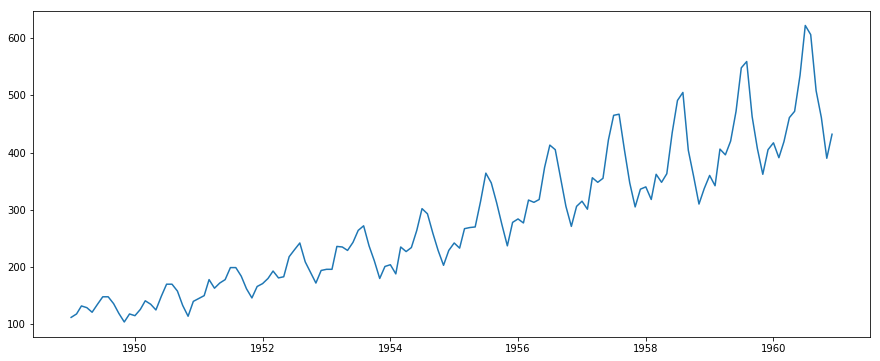

In [12]:
# Plot data 
plt.plot(ts)

## 2) Check Stationarity:

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean= timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
 

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

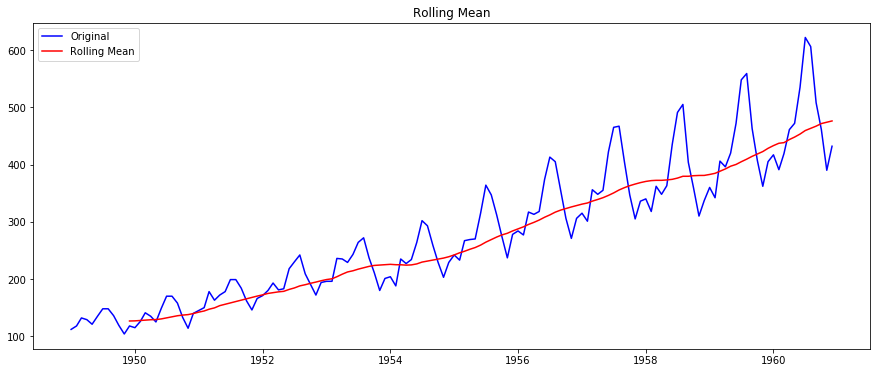

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [21]:
test_stationarity(ts)

In [15]:
# How can you interpreate the results ?
# The results show is that the Test Statistic here is bigger than all Critical Values and p-value is not small (<0.01)
# So, based on the test, we can conclude that the time Series is not stationary.

In [31]:
# Data decomposition:

In [32]:
# Sometimes it is usuful to decompose a time series to better undertasnd the different pattern and to ameliorate the forcast

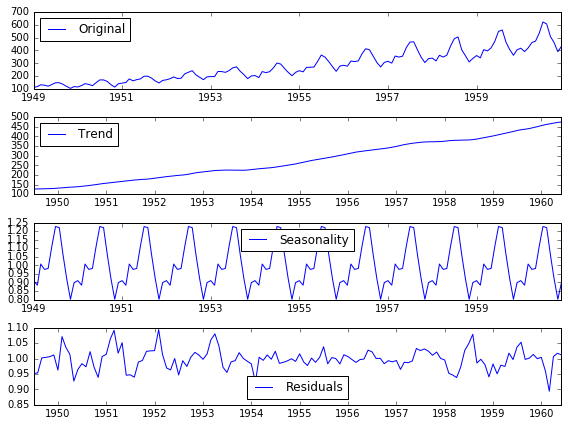

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig=plt.subplots(figsize=(8, 6))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='left')
plt.tight_layout()

In [34]:
# How to make data stationary ?

/Users/samehbf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/samehbf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


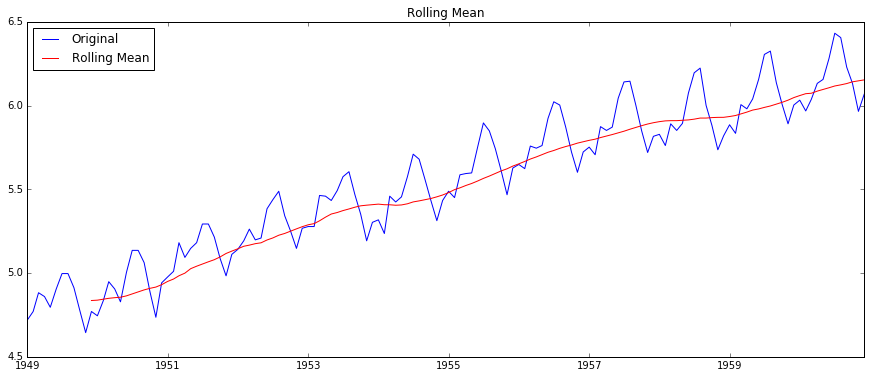

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [35]:
# 1) Reduce trend by applying log:
# Applying a log to elimnate the positive trend.
ts_log = np.log(ts)
test_stationarity(ts_log)

In [36]:
# The data is still non stationary 

In [37]:
# 2) Apply differencing to make time series stationary 
# Differencing can help stabilize the mean of a time series by removing changes in the level of a time series
# and so eliminating trend and seasonality.

In [38]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64

/Users/samehbf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/samehbf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


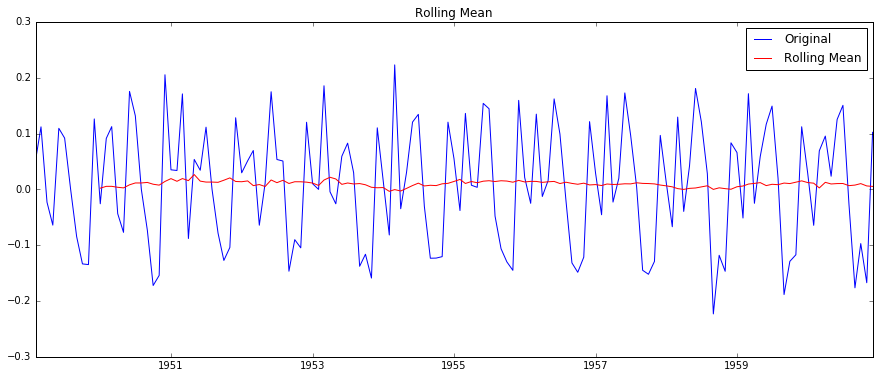

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [39]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [40]:
# What do you think of this time series now ?
# The results show is that the Test Statistic here is lower than Critical Value (1%) and p-value are small (<0.1), so it can be concluded with 99% confidence that the Time Series is stationary.

## 3) ARIMA Modelling and forcasting: 


In [41]:
# In the following, we will be playing with log_ts data that we differenciate one time to make stationary.

### 3.1) Find ARIMA parameters:

An importance concern here is how to determine the value of ‘p’ and ‘q’.
On way to determine p and q: We use two plots to determine these numbers.
Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself.
Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. 
Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

In [42]:
#ACF and PACF plots:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [43]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff.values, nlags = 20)
lag_pacf = pacf(ts_log_diff.values, nlags = 20)


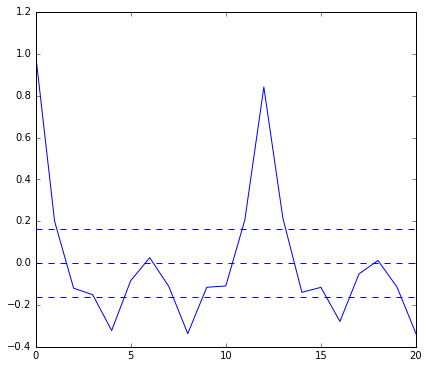

In [44]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--')

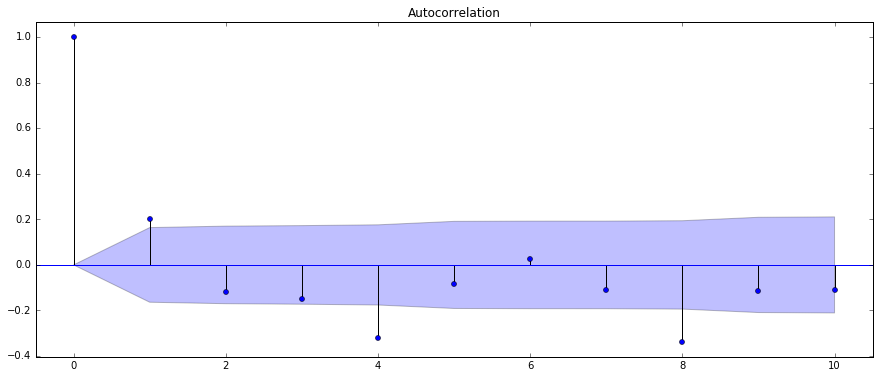

In [45]:
plot_acf(ts_log_diff, lags=10)
plt.show()

In [46]:
# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 2 and gives us the p value

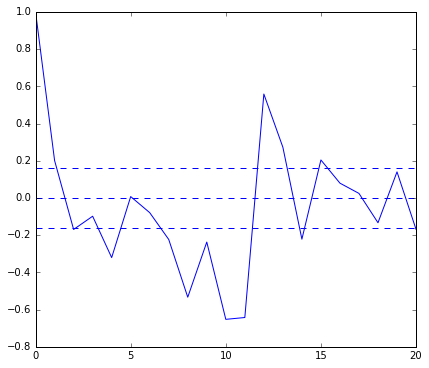

In [47]:
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--')

In [48]:
# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the q value

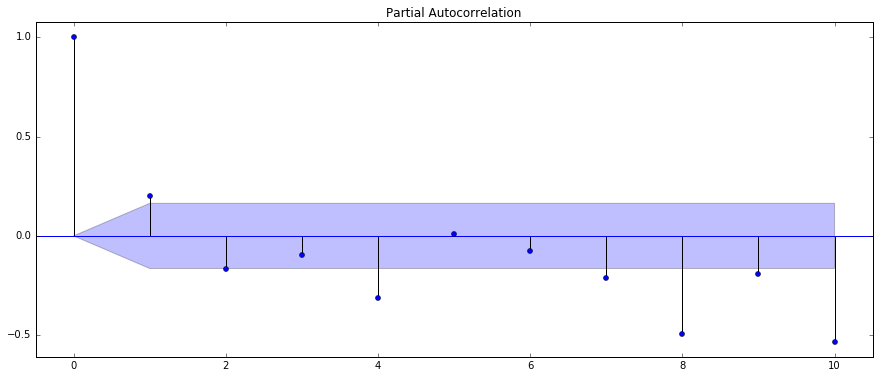

In [49]:
plot_pacf(ts_log_diff, lags=10)
plt.show()

In [50]:
from statsmodels.tsa.arima_model import ARIMA

In [51]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

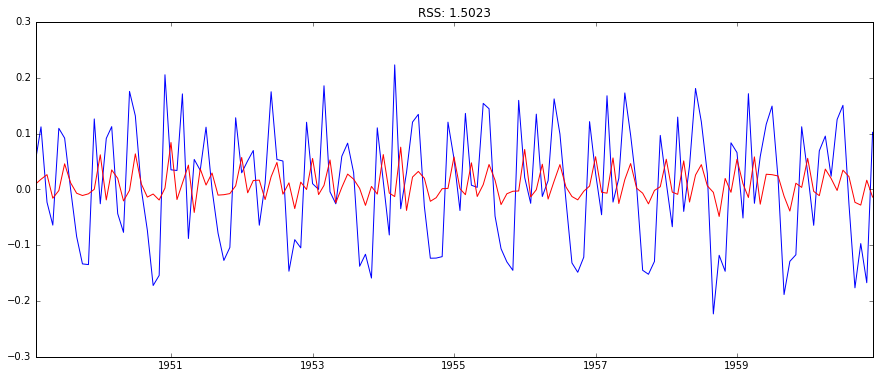

In [59]:
# AR model
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

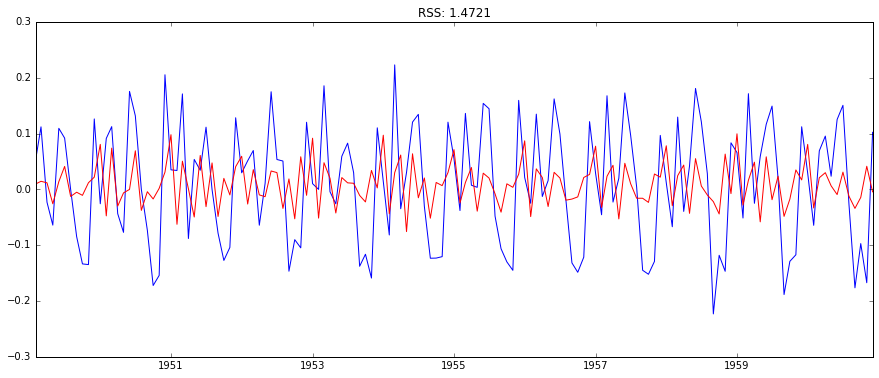

In [61]:
# MA model
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

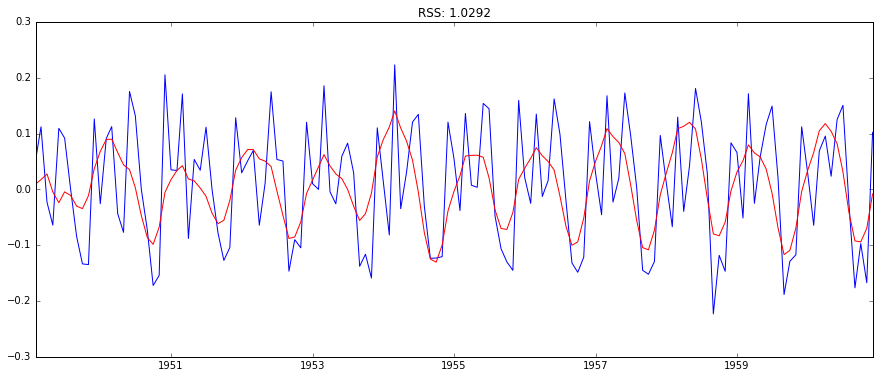

In [62]:
# ARIMA model
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [63]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [64]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [65]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

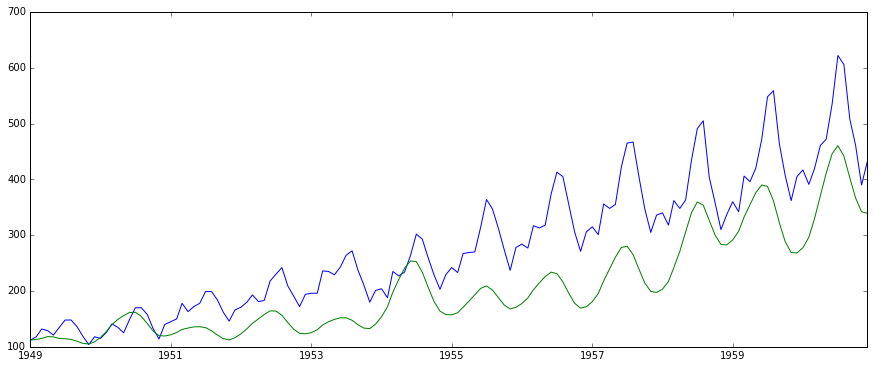

In [66]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
